In [36]:
# importing the required libraries
import numpy as np 
import pandas as pd
# from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
# from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
# from IPython.display import display
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
# from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import joblib
# from sklearn import metrics

In [2]:
# loading dataset
df = pd.DataFrame(pd.read_csv('F:\CUI\QRFS-FYP\QRFS-Dataset\dataset.csv'))
df = df.loc[:,["CATEGORY", "COMPLAINT"]]
df.head()

,CATEGORY,COMPLAINT
0,Software Issues,"My university CMS is misbehaving, it is not sh..."
1,Hardware Issues,The projector is not turning on. Nothing happe...
2,Maintenance and Cleaning,"Classroom 203 is extremely dirty, there is dus..."
3,Scheduling and Management Issues,No classroom is available at the time slot all...
4,Hardware Issues,My university laptop is not charging. The ligh...


In [3]:
print(df.shape)
df.head(3).T

(22, 2)


,0,1,2
CATEGORY,Software Issues,Hardware Issues,Maintenance and Cleaning
COMPLAINT,"My university CMS is misbehaving, it is not sh...",The projector is not turning on. Nothing happe...,"Classroom 203 is extremely dirty, there is dus..."


In [4]:
# finding the unique products
pd.DataFrame(df.CATEGORY.unique()).values

array([['Software Issues'],
       ['Hardware Issues'],
       ['Maintenance and Cleaning'],
       ['Scheduling and Management Issues'],
       ['Network Issues']], dtype=object)

In [5]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df.sample(100, random_state=1, replace=True).copy()
df2.head()

,CATEGORY,COMPLAINT
5,Network Issues,"The portal is very slow in loading, i have tri..."
11,Network Issues,"Internet wifi is down, I cannot connect to the..."
12,Network Issues,"The lan cable in project lab is not working, t..."
8,Hardware Issues,The charging socket in my office is not workin...
9,Software Issues,The university portal does not give any respon...


In [6]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['CATEGORY'].factorize()[0]
category_id_df = df2[['CATEGORY', 'category_id']].drop_duplicates()
category_id_df

,CATEGORY,category_id
5,Network Issues,0
8,Hardware Issues,1
9,Software Issues,2
16,Maintenance and Cleaning,3
13,Scheduling and Management Issues,4


In [7]:
df2.head()

,CATEGORY,COMPLAINT,category_id
5,Network Issues,"The portal is very slow in loading, i have tri...",0
11,Network Issues,"Internet wifi is down, I cannot connect to the...",0
12,Network Issues,"The lan cable in project lab is not working, t...",0
8,Hardware Issues,The charging socket in my office is not workin...,1
9,Software Issues,The university portal does not give any respon...,2


In [8]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'CATEGORY']].values)
print("category_to_id: ", category_to_id)
print()
print("id_to_category: ", id_to_category)

category_to_id:  {'Network Issues': 0, 'Hardware Issues': 1, 'Software Issues': 2, 'Maintenance and Cleaning': 3, 'Scheduling and Management Issues': 4}

id_to_category:  {0: 'Network Issues', 1: 'Hardware Issues', 2: 'Software Issues', 3: 'Maintenance and Cleaning', 4: 'Scheduling and Management Issues'}


In [9]:
# New dataframe
df.head()

,CATEGORY,COMPLAINT
0,Software Issues,"My university CMS is misbehaving, it is not sh..."
1,Hardware Issues,The projector is not turning on. Nothing happe...
2,Maintenance and Cleaning,"Classroom 203 is extremely dirty, there is dus..."
3,Scheduling and Management Issues,No classroom is available at the time slot all...
4,Hardware Issues,My university laptop is not charging. The ligh...


## Visualize the data

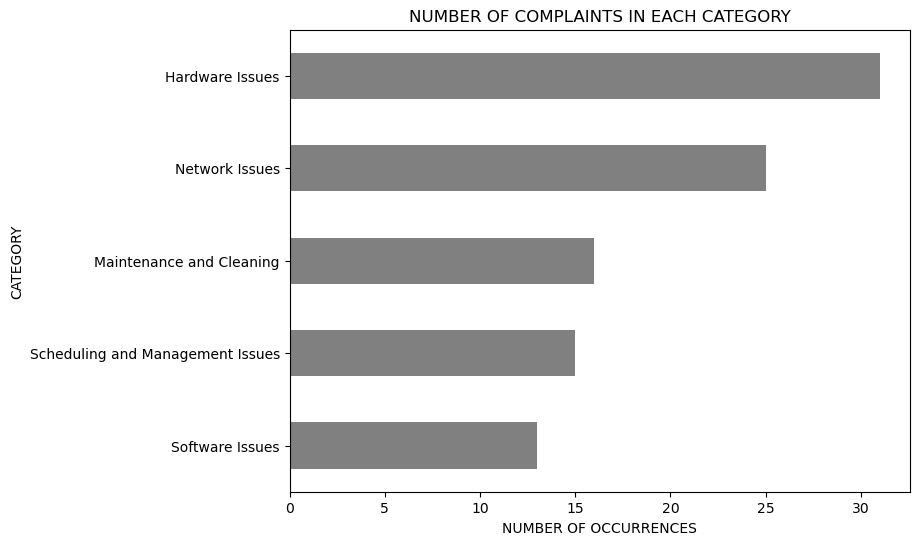

In [35]:
# Let us visualize the data, and see how many numbers of complaints are there per category. We will use Bar chart here.
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey']
df2.groupby('CATEGORY').COMPLAINT.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH CATEGORY')
plt.xlabel('NUMBER OF OCCURRENCES', fontsize = 10);

## Text Processing

#### We will transform the texts into vectors using Term Frequency-Inverse Document Frequency (TFIDF) and evaluate how important a particular word is in the collection of words. For this we need to remove punctuations and do lower casing, then the word importance is determined in terms of frequency.

#### We will be using TfidfVectorizer function with the below parameters:
* min_df: remove the words which has occurred in less than ‘min_df’ number of files.
* Sublinear_tf: if True, then scale the frequency in logarithmic scale.
* Stop_words: it removes stop words which are predefined in ‘english’.

In [11]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')
# We transform each complaint into a vector
features = tfidf.fit_transform(df2.COMPLAINT).toarray()
labels = df2.category_id
print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 100 complaints is represented by 183 features (TF-IDF score of unigrams and bigrams)


In [12]:
# Now, we will find the most correlated terms with each of the defined complaint categories. 
# Here we are finding only three most correlated terms.
# Finding the three most correlated terms with each of the complaint categories
N = 3
print(category_to_id.items())
print()
for CATEGORY, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("n==> %s:" %(CATEGORY))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

dict_items([('Network Issues', 0), ('Hardware Issues', 1), ('Software Issues', 2), ('Maintenance and Cleaning', 3), ('Scheduling and Management Issues', 4)])

n==> Hardware Issues:
  * Most Correlated Unigrams are: turn, turning, socket
  * Most Correlated Bigrams are: cooling coming, coming vents, does turn
n==> Maintenance and Cleaning:
  * Most Correlated Unigrams are: sockets, needs, floor
  * Most Correlated Bigrams are: 206 dim, sockets 2md, power sockets
n==> Network Issues:
  * Most Correlated Unigrams are: connections, slow, internet
  * Most Correlated Bigrams are: 12 limited, connectivity shown, limited connectivity
n==> Scheduling and Management Issues:
  * Most Correlated Unigrams are: concerned, time, timing
  * Most Correlated Bigrams are: term papers, semester kindly, students concerned
n==> Software Issues:
  * Most Correlated Unigrams are: cms, showing, attendance
  * Most Correlated Bigrams are: showing students, attendance students, misbehaving showing


## Splitting the dataset

#### Column ‘Complaint’ will be our X or the input and the Category is out Y or the output.

In [13]:
X = df2['COMPLAINT'] # Collection of documents
y = df2['CATEGORY'] # Target or the labels we want to predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

## Evaluation of Text Classification Model - Training the Model

In [28]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [30]:
# Classification report
print('CLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, target_names= df2['CATEGORY'].unique()))

CLASSIFICATIION METRICS

                                  precision    recall  f1-score   support

                  Network Issues       1.00      1.00      1.00         7
                 Hardware Issues       1.00      0.50      0.67         6
                 Software Issues       1.00      1.00      1.00         2
        Maintenance and Cleaning       0.62      1.00      0.77         5
Scheduling and Management Issues       1.00      1.00      1.00         5

                        accuracy                           0.88        25
                       macro avg       0.93      0.90      0.89        25
                    weighted avg       0.93      0.88      0.87        25



## Prediction

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

In [17]:
fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

In [21]:
model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

#### Now run the prediction

In [19]:
complaint = """the portal is stuck when I try to log in to it"""
print(model.predict(fitted_vectorizer.transform([complaint])))

['Software Issues']


#### Calculating the accuracy of our model using the confusion metrics

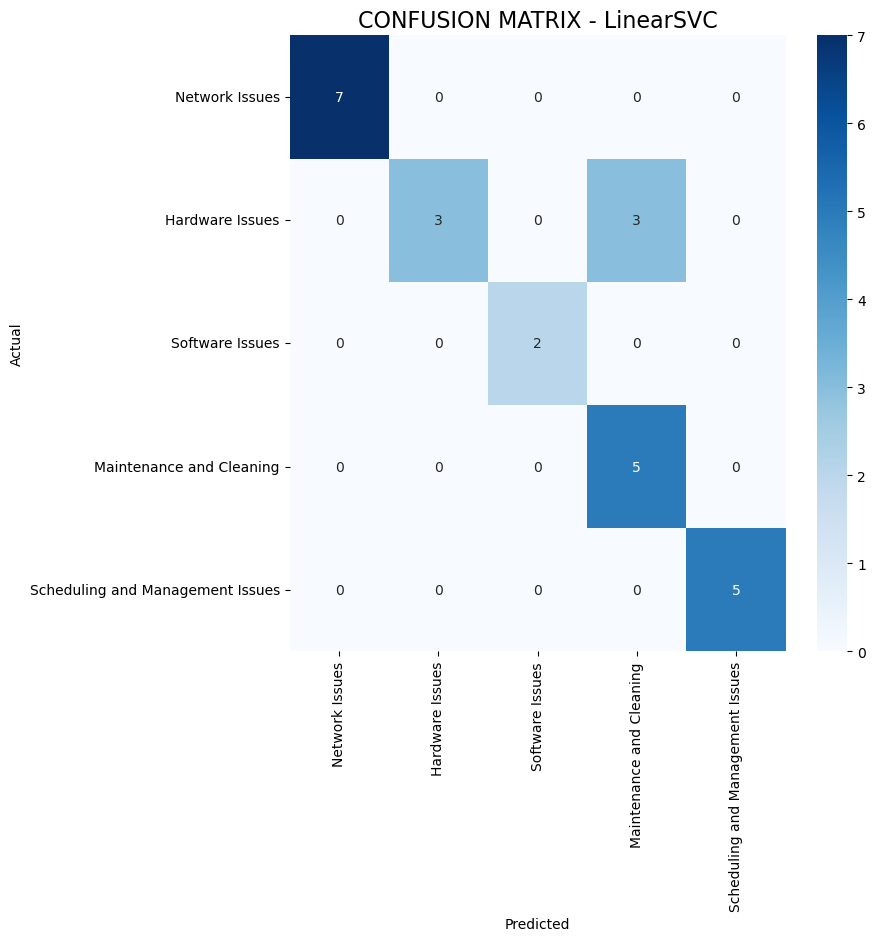

In [32]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.CATEGORY.values, 
            yticklabels=category_id_df.CATEGORY.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC", size=16);

In [37]:
joblib.dump(model, 'recommender_model')

['recommender_model']